# Importación de Librerías

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
SEQ_LEN = 60
BATCH_SIZE = 64

# Uso de "Device"

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carga de datos

In [3]:
data = pd.read_csv('btcusd_1-min_data.csv', nrows=526000)
data.head()
data.count()

Timestamp    526000
Open         526000
High         526000
Low          526000
Close        526000
Volume       526000
dtype: int64

# Preprocesamiento de datos

In [4]:
# Normalizar los datos
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close', 'Volume']])

# Crear secuencias de entrada y salida
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length][3]  # Usamos el precio de cierre como objetivo
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LEN = 30  # Longitud de las secuencias
X, y = create_sequences(data_scaled, SEQ_LEN)

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convertir a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Crear DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Definición de Modelo

In [5]:
class BitcoinLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(BitcoinLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.batch_norm(out[:, -1, :])
        out = self.dropout(out)
        out = self.fc(out)
        return out

input_size = 5  # Número de características (Open, High, Low, Close, Volume)
hidden_size = 10
num_layers = 2
output_size = 1  # Predicción del precio de cierre

model = BitcoinLSTM(input_size, hidden_size, num_layers, output_size).to(device)

# Entrenamiento del Modelo

In [6]:
# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenar el modelo
num_epochs = 5
model.train()

for epoch in range(num_epochs):
    for inputs, targets in train_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

/home/silva/.local/lib/python3.11/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/silva/.local/lib/python3.11/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/5], Loss: 0.0418
Epoch [2/5], Loss: 0.0219
Epoch [3/5], Loss: 0.0401
Epoch [4/5], Loss: 0.0462
Epoch [5/5], Loss: 0.0487


# Evaluar el modelo

Mean Squared Error (MSE): 0.3096
Mean Absolute Error (MAE): 0.5491
R² Score: -37.0419


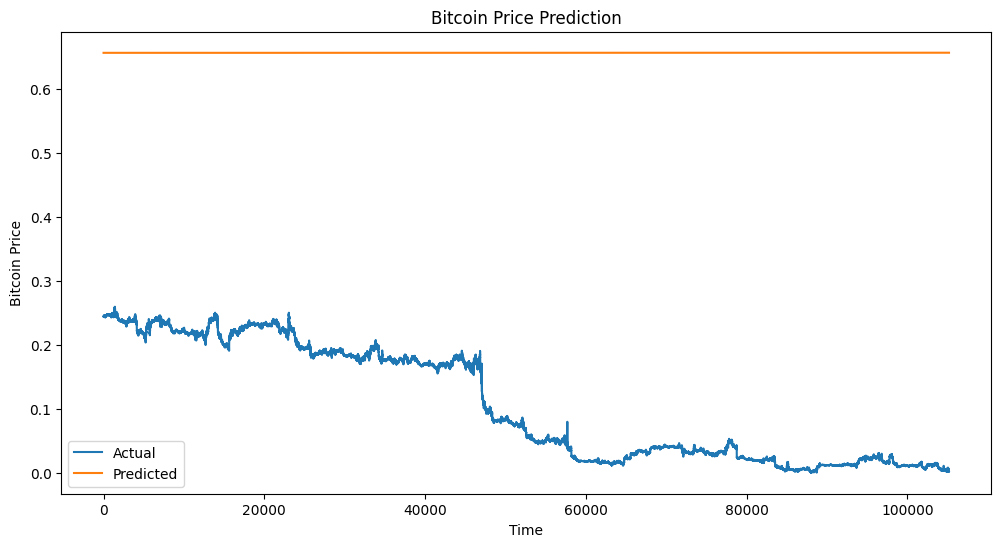

In [9]:
# Evaluar el modelo y obtener las predicciones
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predictions.append(outputs.cpu().numpy())
        actuals.append(targets.cpu().numpy())

# Convertir las listas a arrays
predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

# Calcular las métricas de regresión
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'R² Score: {r2:.4f}')

# Graficar las predicciones y los valores reales
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.legend()
plt.show()